# PyTorch

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My Drive/HSE_DL_2021/03_week

/content/gdrive/My Drive/HSE_DL_2021/03_week


In [3]:
from IPython import display

## Dynamic Computational Graph

После того, как были реализованы архитектура модели и весь процес обучения и валидация сети, при запуске кода в PyTorch происходят следующие этапы:

1. Строится вычислительный граф (направленный ациклический граф), где каждый узел -- это тензор, а ребро, ведущее к дргуому узлу, это выполнение операции над данным тензором, которое ведет к результату - другому тензору.

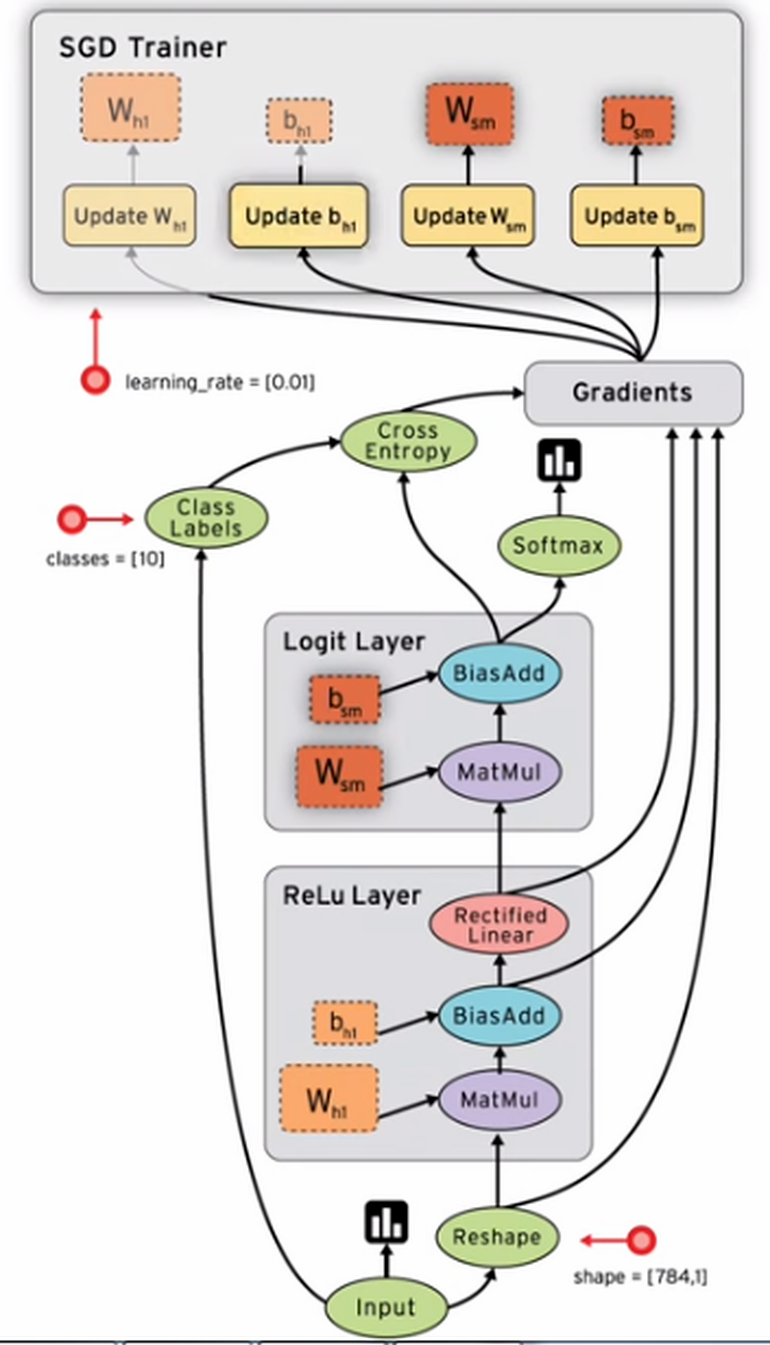

In [4]:
display.Image('images/Graph.png')

Реализуем двухслойную сеть для задачи регрессии. И граф для такой архитектуры бдует выглядить следующим образом:

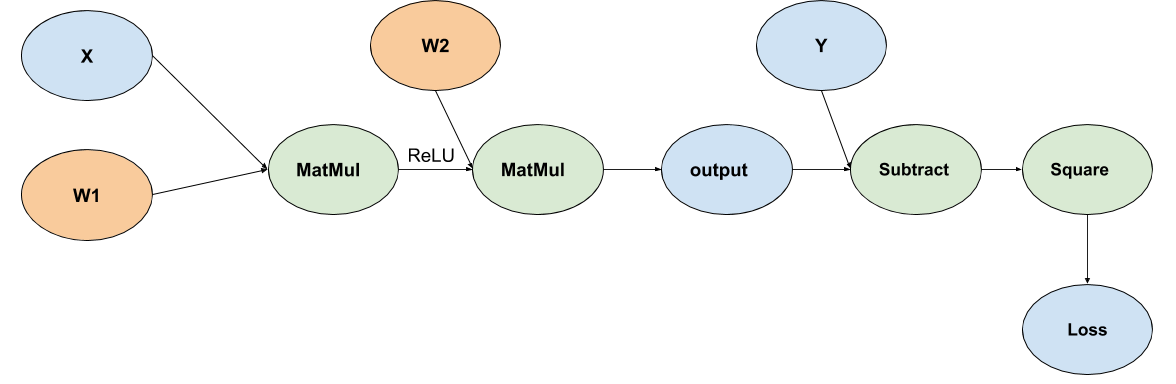

In [5]:
display.Image('images/RegGraph.png')

In [7]:
import torch

dtype = torch.float
# device = torch.device("cpu")

# device = torch.device("cuda:0") # Uncomment this to run on GPU

# how to combine both lines: CPU and GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
batch_size = 64
input_size = 3
hidden_size = 2
output_size = 1

In [11]:
# Create random input and output data
x = torch.randn(batch_size, input_size, device=device, dtype=dtype)
y = torch.randn(batch_size, output_size, device=device, dtype=dtype)

# Randomly initialize weights
w1 = torch.randn(input_size, hidden_size, device=device, dtype=dtype)
w2 = torch.randn(hidden_size, output_size, device=device, dtype=dtype)

learning_rate = 1e-6
for t in range(5):
    # Forward pass: compute predicted y
    h = torch.mm(x, w1)  # another way x @ w1
    h_relu = h.clamp(min=0)

    y_pred = torch.mm(h_relu, w2)  # h_relu @ w2
    # Compute and print loss
    loss = (y_pred - y).pow(2).sum().item()
    print(loss)

114.29711151123047
114.29711151123047
114.29711151123047
114.29711151123047
114.29711151123047


In [12]:
x.shape, w1.shape, w2.shape

(torch.Size([64, 3]), torch.Size([3, 2]), torch.Size([2, 1]))

## Autograd

2. Еще одно фундаментальное понятие и важный элемент при построении графа -- это [__Autograd__](https://pytorch.org/docs/stable/notes/autograd.html) -- автоматическое дифференцирование.

Для того чтобы с помощью стохастического градиентного спуска обновить обучаемые параметры сети, нужно посчитать градиенты. И как известно, обновление весов, которые учавтсвуют в нескольких операциях, происходит по `правилу дифференцирования сложной функции` (цепное правило или __chain rule__).

$h_{relu} = ReLU(XW_1)$ \

$y_{pred} = h_{relu} \cdot W_2$ \

$L = (y_{pred}-y)^2$

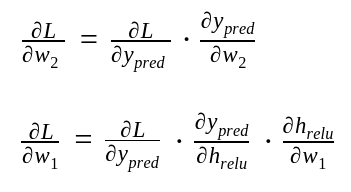

In [13]:
display.Image('images/RegChainRule.png')

То есть (1) вычислительный граф позволяет определить последовательность операций, а (2) автоматическое дифференцирование посчитать нужные градиенты.

Если бы `Autograd` не было, то тогда backprop надо было бы реализовывать самим, и как это бы выглядело?

Рассмотрим на примере, как посчиать градиенты для весов из входного слоя, где входной вектора `X` состоит из 3-х компонент. А входной слой вторую размерность имеет равной 2. 

После чего это идет в `ReLU`, но для простоты опустим на время ее, и посмотрим как дальше это идет по сети.

Ниже написано, как это все вычисляется и приводит нас к значению целевой функции для одного наблюдения

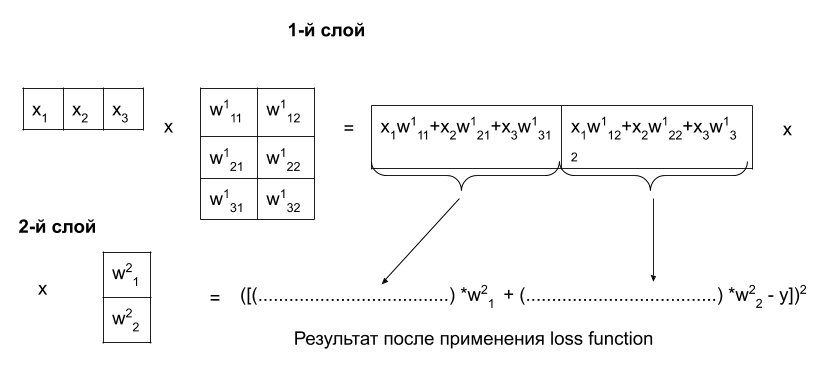

In [14]:
display.Image('images/1.png')

Тогда, чтобы посчитать градиент по первому элементу из обучаемой матрицы на первом слое, необходимо взять производоную у сложной функции. А этот как раз делается по `chain rule`: сначала берем у внешней, потом спускаемся на уровень ниже, и так пока не додйдем до то функции, после которой эта перменная уже нигде не участвует:

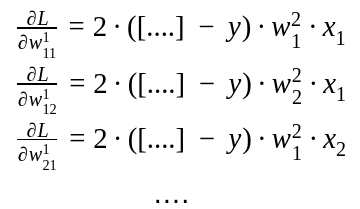

In [15]:
display.Image('images/2.png')

Перепишем это все в матричном виде, то есть сделаем аналог вида матрицы весов из первого слоя, но там уже будут её градиенты, котоыре будут нужны чтобы как раз обновить эти веса:

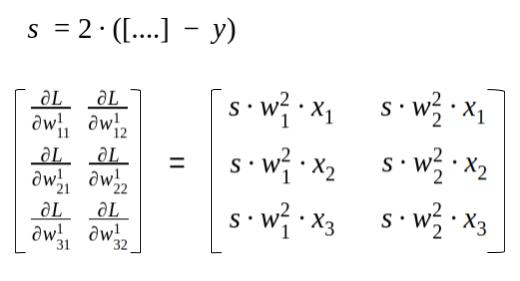

In [16]:
display.Image('images/3.jpg')


Как видно, здесь можно вектор X вынести, то есть разделить на две матрицы:

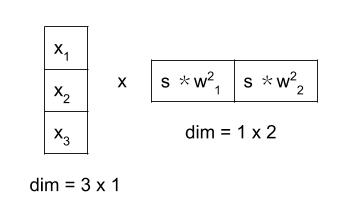

In [17]:
display.Image('images/4.jpg')

То есть уже видно, что будем траспонировать входной вектор(матрицу). Но надо понимать, что в реальности у нас не одно наблюдение в батче, а несколько, тогда запись немного изменит свой вид:

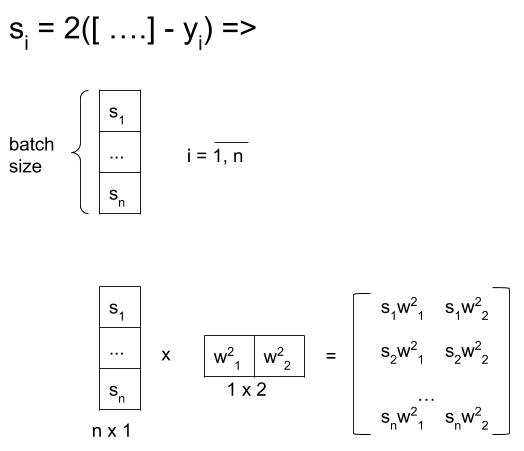

In [18]:
display.Image('images/5.jpg')


Теперь мы видим, как на самом деле вычисляется вот те самые частные производные для вектора X, то есть видно, как математически это можно записать, а именно:

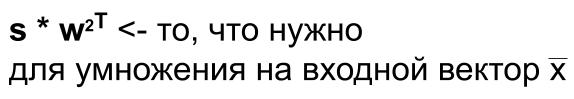

In [19]:
display.Image('images/6.jpg')


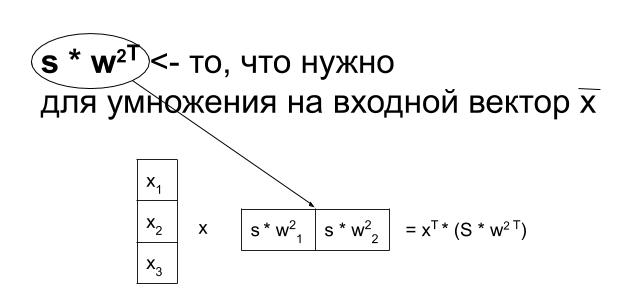

In [20]:
display.Image('images/7.jpg')


**Вопрос на понимание формул:** почему на картинке выше **$x^T$** транспонирован?

Уже можно реализовать. Понятно, что транспонируется, что нет, и что на что умножается.

Но помним про ReLU. Для простоты опустили, но теперь её учесть будет легче. 

Так как после первого слоя идет ReLU, а значит, занулились те выходы первого слоя, которые были __меньше__ нуля. Получается, что во второй слой не все дошло, тогда нужно обнулить, что занулил ReLU. 

Что занулил ReLU, мы можем выяснить при `forward pass`, а где именно поставить нули, то надо уже смотреть относительно `backward propagation`, на том выходе, где последний раз участвовал выход после ReLU, то есть:

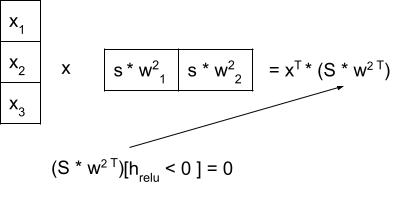

In [21]:
display.Image('images/8.jpg')


Теперь реализуем эти формулы на PyTorch:

In [22]:
# Create random input and output data
x = torch.randn(batch_size, input_size, device=device, dtype=dtype, requires_grad=True)
y = torch.randn(batch_size, output_size, device=device, dtype=dtype, requires_grad=True)

# Randomly initialize weights
w1 = torch.randn(input_size, hidden_size, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(hidden_size, output_size, device=device, dtype=dtype, requires_grad=True)

learning_rate = 1e-6


# One Forward pass: compute predicted y
h = torch.mm(x, w1)  # another way x @ w1

h_relu = h.clamp(min=0)

y_pred = torch.mm(h_relu, w2)  # h_relu @ w2

loss = (y_pred - y).pow(2).sum()

$h_{relu} = ReLU(XW_1)$ \

$y_{pred} = h_{relu} \cdot W_2$ \

$L = (y_{pred}-y)^2$

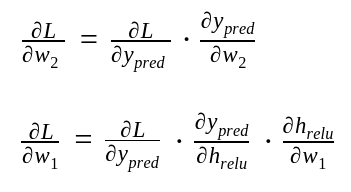

In [23]:
display.Image('images/RegChainRule.png')

In [33]:
grad_h = torch.tensor([[1,2,3],
                       [1,2,3]])
print(grad_h)
h = torch.tensor([[-1,2,3],
                  [1,-2,3]])
print(h, '\n\n')

grad_h[h < 2] = 10000000
grad_h

tensor([[1, 2, 3],
        [1, 2, 3]])
tensor([[-1,  2,  3],
        [ 1, -2,  3]]) 




tensor([[10000000,        2,        3],
        [10000000, 10000000,        3]])

In [25]:
# TODO
s = 2*(y_pred - y)
grad_w2 = h_relu.t() @ s

# TODO
grad_h = s @ w2.t()
grad_h[h<0] = 0
grad_w1 = x.t() @ grad_h 

# # Update weights using gradient descent
# w1 -= learning_rate * grad_w1
# w2 -= learning_rate * grad_w2

loss.backward()
print('Gradient for w1 is calculated correctly:', (w1.grad == grad_w1).all().item())
print('Gradient for w2 is calculated correctly:', (w2.grad == grad_w2).all().item())

Gradient for w1 is calculated correctly: True
Gradient for w2 is calculated correctly: True


Благодаря `Autograd` реализацию `chain rule` можно избежать, так как для более сложных нейронных сетей вручную такое реализовать сложно, при этом сделать это эффективным.

Для того чтобы PyTorch понял, за какими переменными надо "следить", то есть указать, что именно "эти" переменные являются обучаемыми, необходимо при создании тензора в качестве аттрибута указать __requires_grad=True__:

In [34]:
w1 = torch.randn(input_size, hidden_size, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(hidden_size, output_size, device=device, dtype=dtype, requires_grad=True)

In [ ]:
learning_rate = 1e-5
for t in range(5000):
    y_pred = x.mm(w1).clamp(min=0).mm(w2)

    loss = (y_pred - y).pow(2).mean()
    if t % 100 == 99:
        print(t, loss.item())
    
    # Теперь подсчет градиентов для весов происходит при вызове backward
    loss.backward()
   
    # Обновляем значение весов, но укзаываем, чтобы PyTorch не считал эту операцию, 
    # которая бы учавствовала бы при подсчете градиентов в chain rule
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad
        
        # Теперь обнуляем значение градиентов, чтобы на следующем шаге 
        # они не учитывались при подсчете новых градиентов,
        # иначе произойдет суммирвоание старых и новых градиентов
        w1.grad.zero_()
        w2.grad.zero_()

        # optimizer = Adam(model.parameters(), lr)
        # optimizer.zero_grad()

Осталось еще не вручную обновлять веса, а использовать адаптивные методы градинетного спсука. Для этого нужно использовать модуль __optim__. А помимо оптимайзера, еще можно использовать готовые целевые функции из модлуя __nn__.

In [37]:
import torch.optim as optim

loss_fn = torch.nn.MSELoss(reduction='mean')

learning_rate = 1e-6
optimizer = torch.optim.Adam([w1, w2], lr=learning_rate)
 
for t in range(500):
    optimizer.zero_grad()
    
    y_pred = x.mm(w1).clamp(min=0).mm(w2)
    
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())
    
    loss.backward()
   
    optimizer.step()

99 1.4483157396316528
199 1.4478217363357544
299 1.4473282098770142
399 1.4468350410461426
499 1.4463419914245605


После того, как мы сделали backward, в этот момент посчитались градиенты и граф уничтожился, то есть стёрлись все пути, которые связывали тензоры между собой. Это значит, что еще раз backward сделать не поулчится, будет ошибка. Но если вдруг нужно считать градиенты еще раз, то нужно при вызове backward задать `retain_graph=True`.

Еще важный аттрибут, который есть у Tensor -- это `grad_fn`. В этом аттрибуте указывается та функция, посредством которой был создан этот тензор. Так PyTorch понимает, как именно считать по нему градиент.

In [ ]:
y_pred.grad_fn

Также можно контролировать, должны ли градиенты течь или нет.

In [38]:
x = torch.tensor([1.], requires_grad=True)
with torch.no_grad():
    # .....
    # ....
    # ....
    with torch.enable_grad():
        y = x * 2
y.requires_grad

True

## Почему Backprop надо понимать

1. Backprop позволяет понимать, как те или иные операции, сложные конструкции в сети влияют на обнолвение весов.
Почему лучше сделать конкатенацию тензоров, а не поэлементное сложение. Для этого нужно посмотреть на backprop, как будут обновляться веса.

2. Даже на таком маленьком пример двуслойной MLP можно уже увидеть, когда `ReLU`, как функция активация, не очень хорошо применять. Если разреженные данные, то получить на выходе много нулей вероятнее, чем при использовании `LeakyReLU`, то есть градиенты будут нулевыми и веса никак не будут обновляться => сеть не обучается!

3. В архитектуре могут встречаться недифференцируемые операции, и первое - это нужно понять, потому что при обучении сети это может быть не сразу заметно, просто качество модели будет плохое, и точность хорошую не поулчится достичь.

